In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈

# GPU 선택 -> '1': 두 번째
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# GPU 메모리의 동적 할당 허용
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'thx',
    'meet',
    'nice_to_meet_you'
]

data = np.concatenate([
    np.load('dataset/seq_thx_1711306226.npy'),
    np.load('dataset/seq_meet_1711306246.npy'),
    np.load('dataset/seq_nice_to_meet_you_1711306273.npy'),
], axis=0)

data.shape
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(330, 5, 100)

In [3]:
# 시퀀스의 마지막 열 제외한 모든 열 가져와 할당
# 첫 번째 행의 마지막 열은 라벨 값
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(data.shape)
# print(data[0,1,:])
print(labels.shape)
print(np.unique(labels))    # 레이블 값 출력

(330, 5, 100)
(330,)
[0. 1.]


In [4]:
from tensorflow import keras
from keras.utils import to_categorical

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(330, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)  # 입력 데이터
y_data = y_data.astype(np.float32)  # 레이블

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(297, 5, 99) (297, 3)
(33, 5, 99) (33, 3)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

# compile(최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, 50 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
 1/10 [==>...........................] - ETA: 11s - loss: 6.3406 - acc: 0.2188
Epoch 1: val_acc improved from -inf to 0.72727, saving model to models\model.h5
10/10 [==============================] - 2s 50ms/step - loss: 2.4664 - acc: 0.5286 - val_loss: 0.5483 - val_acc: 0.7273 - lr: 0.0010
Epoch 2/200
 1/10 [==>...........................] - ETA: 0s - loss: 1.4004 - acc: 0.6250
Epoch 2: val_acc improved from 0.72727 to 0.75758, saving model to models\model.h5
10/10 [==============================] - 0s 13ms/step - loss: 0.5780 - acc: 0.8013 - val_loss: 0.5565 - val_acc: 0.7576 - lr: 0.0010
Epoch 3/200
 1/10 [==>...........................] - ETA: 0s - loss: 0.4535 - acc: 0.8438
Epoch 3: val_acc improved from 0.75758 to 0.87879, saving model to models\model.h5
10/10 [==============================] - 0s 13ms/step - loss: 0.5216 - acc: 0.8047 - val_loss: 0.4693 - val_acc: 0.8788 - lr: 0.0010
Epoch 4/200
 6/10 [=================>............] - ETA: 0s - loss: 0.3467 - acc: 0

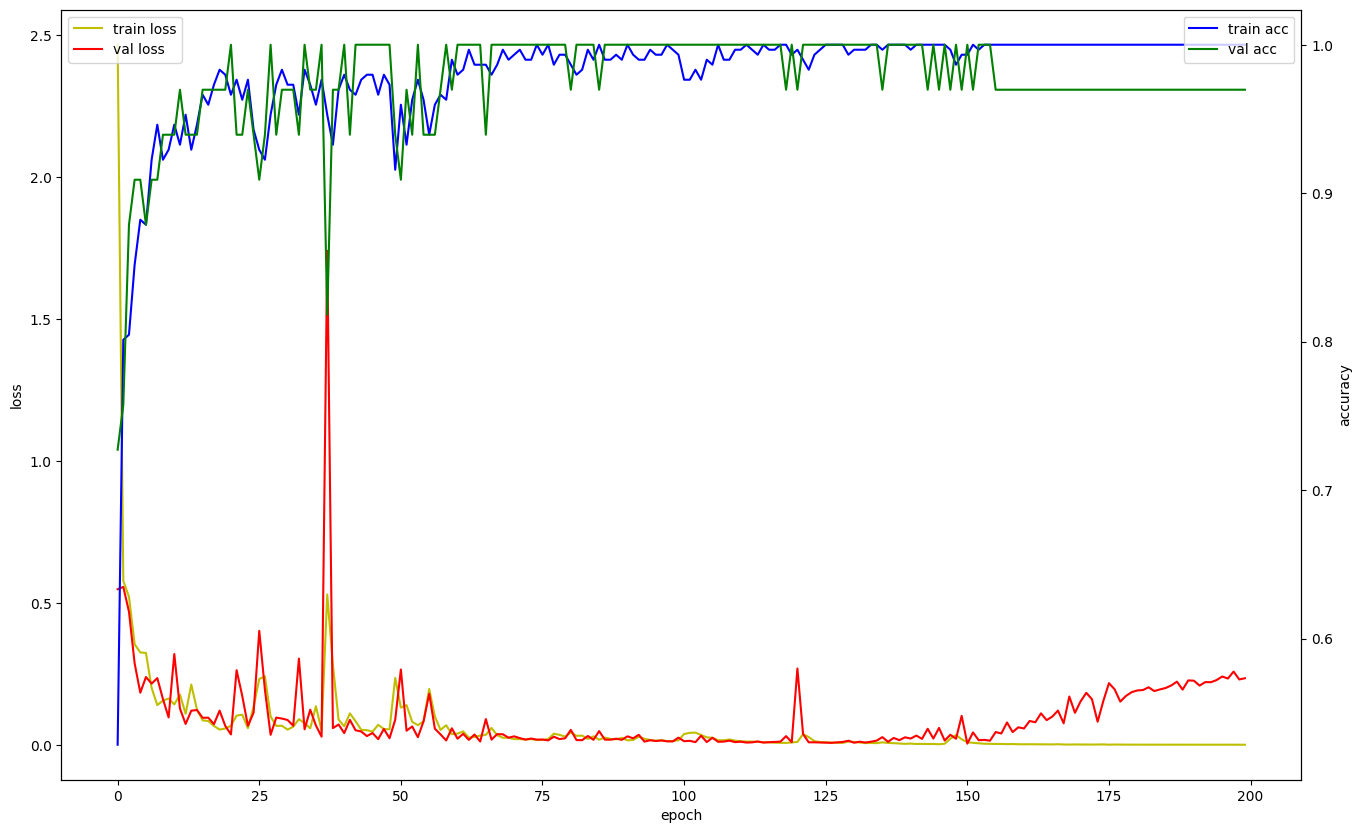

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

# 다중 레이블 혼동 행렬로 모델 평가
# [[True Negative, False Positive],
# [False Negative, True Positive]]
multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

2/2 [==============================] - 0s 2ms/step


array([[[16,  0],
        [ 0, 17]],

       [[17,  0],
        [ 0, 16]]], dtype=int64)